<a href="https://colab.research.google.com/github/AntonPrazdnichnykh/dul_2021/blob/hw8/Homework/hw8/Homework8_DRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 281 (delta 68), reused 55 (delta 51), pack-reused 163
Receiving objects: 100% (281/281), 53.75 MiB | 33.32 MiB/s, done.
Resolving deltas: 100% (125/125), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul

In [1]:
from dul_2021.utils.hw8_utils import *

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from tqdm import trange

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

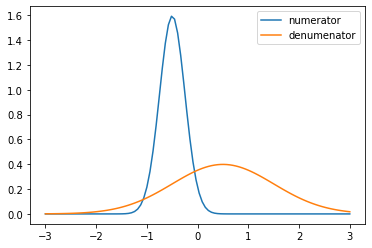

In [ ]:
# distributions
plot_data_q1()

In [ ]:
class KMM(nn.Module):
  def __init__(self, hd, sigma=1):
    super().__init__()

    self.r = nn.Sequential(
        nn.Linear(1, hd), 
        nn.ReLU(),
        nn.Linear(hd, hd), 
        nn.ReLU(),
        nn.Linear(hd, 1),
        nn.Softplus()
    )

    self.sigma = sigma

  def get_kernel(self, x, y):
    return torch.exp(-torch.cdist(x, y)**2 / (2 * self.sigma))

  @torch.no_grad()
  def ratio(self, data):
    return self.r(data).cpu().numpy()

  def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
    loader_nu = DataLoader(data_nu, 
                          batch_size=batch_size, 
                          shuffle=True)
        
    loader_de = DataLoader(data_de, 
                                batch_size=batch_size, 
                                shuffle=True)
    
    optimizer = Adam(self.r.parameters(), lr=lr)

    for epoch in trange(num_epochs):
        for (batch_nu, batch_de) in zip(loader_nu, loader_de):
            batch_nu = batch_nu.view(-1, 1).float().to(device)
            batch_de = batch_de.view(-1, 1).float().to(device)

            r_star = self.r(batch_de)

            K_de_de = self.get_kernel(batch_de, batch_de)hd=CONFIG['hd'], sigma=CONFIG['sigma']
            K_de_nu = self.get_kernel(batch_de, batch_nu)

            loss = (r_star.T @ K_de_de @ r_star - 2 * (r_star.T @ K_de_nu).sum()) / batch_size**2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
CONFIG = {
    'model': {
            'hd': 128,
            'sigma': 0.5,
    },
    'training': {
        'num_epochs': 100,
    }
}

In [ ]:
def q1(data_nu, data_de):
  """
  data_nu - An [n_nu] dataset with samples from numerator's distribution
  data_de - An [n_de] dataset with samples from denominators's distribution
  
  Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
  """
  # your code goes here
  model = KMM(**CONFIG['model'])
  model.to(device)
  model.fit(data_nu, data_de, **CONFIG['training'])

  # you need to calculate density ratio on x and return it
  x = np.linspace(-2., 2, num=100)
  x = torch.tensor(x.reshape(-1, 1), dtype=torch.float32, device=device)

  return model.ratio(x)

100%|██████████| 100/100 [00:04<00:00, 23.24it/s]


<Figure size 432x288 with 0 Axes>

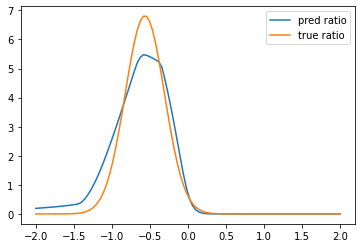

In [ ]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [4]:
from itertools import chain

In [5]:
class Classifier(nn.Module):
  def __init__(self, hd, ld):
    super().__init__()
    
    self.conv_net = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, 2, 1),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, 2, 1),
        nn.ReLU()
    )

    self.cls_head = nn.Sequential(
        nn.Linear(4 * 4 * 128 + ld, hd), 
        nn.ReLU(),
        nn.Linear(hd, hd), 
        nn.ReLU(),
        nn.Linear(hd, 1)
    )

  def forward(self, x, z):
    batch_size = x.size(0)
    x = self.conv_net(x)
    x = torch.cat((x.view(batch_size, -1), z), dim=1)
    return self.cls_head(x)


In [6]:
class Encoder(nn.Module):
  def __init__(self, nd, ld):
    super().__init__()
    self.conv_net = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1), 
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.ReLU(), 
        nn.Conv2d(64, 128, 3, 2, 1), 
        nn.ReLU(), 
        nn.Conv2d(128, 128, 3, 2, 1), 
        nn.ReLU(), 
    )

    self.linear = nn.Linear(4 * 4 * 128 + nd, ld)

    self.nd = nd

  def forward(self, x):
    batch_size = x.size(0)
    x = self.conv_net(x)
    noise = torch.randn(batch_size, self.nd, device=device)
    # print(batch_size, x.shape, noise.shape)
    x = torch.cat((x.view(batch_size, -1), noise), dim=1)
    return self.linear(x)

In [7]:
class Decoder(nn.Module):
  def __init__(self, ld):
    super().__init__()
    self.up_net = nn.Sequential(
        nn.ConvTranspose2d(128, 128, 3, 2, 1), 
        nn.ReLU(), 
        nn.ConvTranspose2d(128, 64, 4, 2, 1), 
        nn.ReLU(), 
        nn.ConvTranspose2d(64, 32, 4, 2, 1), 
        nn.ReLU(), 
        nn.Conv2d(32, 1, 3, 1, 1)
    )

    self.linear = nn.Linear(ld, 4 * 4 * 128)
  
  def forward(self, z):
    batch_size = z.size(0)
    x = F.relu(self.linear(z))
    return self.up_net(x.view(batch_size, 128, 4, 4))


In [11]:
class AVB(nn.Module):
  def __init__(self, hd=128, nd=32, ld=32):
    super().__init__()
    self.classifier = Classifier(hd, ld)
    self.encoder = Encoder(nd, ld)
    self.decoder = Decoder(ld)
    self.nd = nd

  def loss(self, x):
    batch_size = x.size(0)
        
    z_phi = self.encoder(x)
    x_theta = self.decoder(z_phi)

    T_true = self.classifier(x, z_phi)

    recon_loss = (x_theta - x).pow(2).view(batch_size, -1).sum(1)
    elbo_loss = recon_loss + T_true

    pos_loss = - torch.log(torch.sigmoid(self.classifier(x, z_phi.detach()))).mean()

    neg_loss = - torch.log(
        1 - torch.sigmoid(self.classifier(x, torch.randn(batch_size, self.nd, device=device)))
        ).mean()

    cls_loss = pos_loss + neg_loss

    return elbo_loss.mean(), cls_loss.mean()

  @torch.no_grad()
  def test(self, testloader):
    avg_elbo_loss = 0
    avg_cls_loss = 0
    n_elements = 0
    for batch in testloader:
      batch_size = batch.size(0)
      batch = batch.to(device)

      elbo_loss, cls_loss = self.loss(batch)
      avg_elbo_loss += batch_size * elbo_loss
      avg_cls_loss += batch_size * cls_loss
      n_elements += batch_size

    return avg_elbo_loss.item() / n_elements, avg_cls_loss.item() / n_elements

  def fit(self, train_data, test_data, batch_size=512, lr=1e-3, num_epochs=10):
    train_data = train_data.astype(np.float32) * 2 - 1
    train_data = torch.tensor(train_data.transpose(0, 3, 1, 2), dtype=torch.float32)
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    test_data = test_data.astype(np.float32) * 2 - 1
    test_data = torch.tensor(test_data.transpose(0, 3, 1, 2), dtype=torch.float32)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    cls_opt = Adam(self.classifier.parameters(), lr=lr)
    enc_dec_opt = Adam(chain(self.encoder.parameters(), self.decoder.parameters()), lr=lr)

    train_elbo_losses = []
    train_cls_losses = []
    test_elbo_losses = []
    test_cls_losses = []

    test_elbo_loss, test_cls_loss = self.test(testloader)
    test_elbo_losses.append(test_elbo_loss)
    test_cls_losses.append(test_cls_loss)

    for epoch in trange(num_epochs, desc="Training"):
      for batch in trainloader:
        batch = batch.to(device)

        elbo_loss, cls_loss = self.loss(batch)

        enc_dec_opt.zero_grad()
        elbo_loss.backward()
        enc_dec_opt.step()

        cls_opt.zero_grad()
        cls_loss.backward()
        cls_opt.step()

        train_elbo_losses.append(elbo_loss.item())
        train_cls_losses.append(cls_loss.item())

      test_elbo_loss, test_cls_loss = self.test(testloader)
      test_elbo_losses.append(test_elbo_loss)
      test_cls_losses.append(test_cls_loss)

    return (np.array(train_elbo_losses),
            np.array(train_cls_losses),
            np.array(test_elbo_losses),
            np.array(test_cls_losses))

  @torch.no_grad()
  def sample(self, n=100):
    z_sampled = torch.randn(n, self.nd, device=device)
    samples = self.decoder(z_sampled).clamp(-1, 1)
    samples = (samples + 1) / 2
    return samples.cpu().numpy().transpose(0, 2, 3, 1)

In [14]:
def q2(train_data, test_data):
  """
  train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
   Returns
  - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
  - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
  - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
  """
  model = AVB()
  model.to(device)
  train_elbo_losses, train_cls_losses, test_elbo_losses, test_cls_losses = model.fit(train_data, test_data, num_epochs=20)
  samples = model.sample()

  return train_elbo_losses, train_cls_losses, test_elbo_losses, test_cls_losses, samples

Training: 100%|██████████| 20/20 [14:25<00:00, 43.28s/it]


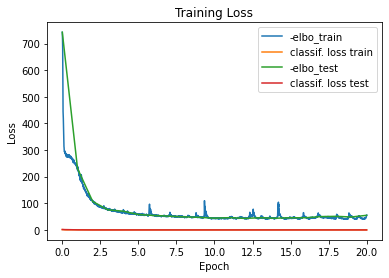

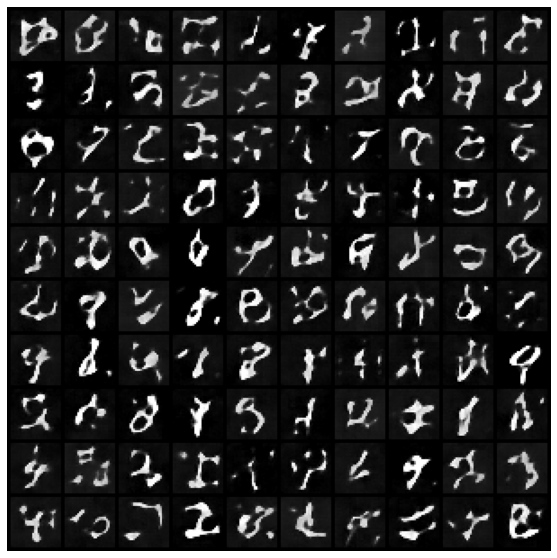

In [15]:
q2_results(q2)